In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

pythia, pythia_tokenizer, pythia_data, pythia_ratio = load_stuff(
    "EleutherAI/pythia-125m-deduped"
)

Using custom data configuration default-17b5822e070b1eaf
/mnt/ssd-1/nora/miniconda3/lib/python3.10/site-packages/datasets/builder.py:712: FutureWarning: 'use_auth_token' was deprecated in version 2.7.1 and will be removed in 3.0.0. Pass `use_auth_token` to the initializer/`load_dataset_builder` instead.
  warnings.warn(
Found cached dataset json (/mnt/ssd-1/nora/huggingface/datasets/json/default-17b5822e070b1eaf/0.0.0)


In [6]:
from transformers import AutoConfig

AutoConfig.from_pretrained("EleutherAI/pythia-12b-deduped")

Downloading:   0%|          | 0.00/538 [00:00<?, ?B/s]

GPTNeoXConfig {
  "_name_or_path": "EleutherAI/pythia-12b-deduped",
  "architectures": [
    "GPTNeoXForCausalLM"
  ],
  "bos_token_id": 0,
  "eos_token_id": 0,
  "hidden_act": "gelu",
  "hidden_size": 5120,
  "initializer_range": 0.02,
  "intermediate_size": 20480,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neox",
  "num_attention_heads": 40,
  "num_hidden_layers": 36,
  "rotary_emb_base": 10000,
  "rotary_pct": 0.25,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "use_parallel_residual": true,
  "vocab_size": 50688
}

In [104]:
import torch as th


@th.jit.script
def quantize_prebinned(x: th.Tensor, quantiles: th.Tensor) -> th.Tensor:
    """Compress a tensor by quantizing it to 8-bit signed integers.

    This function assumes that the quantiles have already been computed.
    """
    assert th.is_floating_point(x) and th.is_floating_point(quantiles)

    # Map to bin indices
    indices = th.bucketize(x, quantiles, out_int32=True)

    # Center the indices about 0 so we can use 8-bit signed integers
    indices -= 128
    return indices.to(th.int8)


@th.jit.script
def quantile_quantize(x: th.Tensor) -> tuple[th.Tensor, th.Tensor]:
    """Compress a tensor by quantizing it to 8-bit signed integers."""

    NUM_BINS = 256
    if not th.is_floating_point(x):
        raise TypeError("Input must be floating point")
    if x.numel() < NUM_BINS:
        raise ValueError("Must have at least 256 elements")

    grid = th.linspace(0, 1, NUM_BINS + 1, device=x.device, dtype=x.dtype)[1:-1]
    quantiles = x.quantile(grid)
    quantized = quantize_prebinned(x, quantiles)

    return quantized, quantiles


@th.jit.script
def quantile_dequantize(x: th.Tensor, quantiles: th.Tensor) -> th.Tensor:
    assert x.dtype == th.int8 and th.is_floating_point(quantiles)

    # Map to quantiles
    return quantiles[x.add(128).long()]


In [47]:
th.tensor(0 - 256 // 2, dtype=th.int8)

tensor(-128, dtype=torch.int8)

In [105]:
foo = th.randn(10_000, 10)
quantized, quantiles = quantile_quantize(foo)
dequantized = quantile_dequantize(quantized, quantiles)

In [1]:
from typing import Sequence

def prediction_depth(traj: Sequence) -> int:
    """The earliest index after which the predictions are all equal to the final one."""
    last = traj[-1]

    for i, x in enumerate(reversed(traj)):
        # We found the last prediction that's different from the final one
        if x != last:
            return len(traj) - i

    # Every prediction is equal to the final one
    return 0

In [2]:
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm
import torch as th

def load_time_depths(root: str, task: str = "lambada_openai", limit = None):
    across_time = defaultdict(list)
    paths = sorted(
        (int(path.stem[4:]), path)
        for path in Path(root).glob("step*")
    )

    for step, step_dir in tqdm(paths):
        if limit and step > limit:
            continue

        try:
            ckpt_results = th.load(
                step_dir / f"{task}_per_doc.pt",
                map_location="cpu",
            )
        except FileNotFoundError:
            break

        for h, v in ckpt_results.items():
            across_time[h].extend(v["greedy_pred"])

    return {
        k: prediction_depth(v)
        for k, v in across_time.items()
        if v
    }

# time_depths = load_time_depths(
#     "/mnt/ssd-1/nora/real-lenses/pythia/6.7b-deduped/downstream-across-time",
#     "lambada_openai",
# )

In [3]:
from scipy.stats import spearmanr
import torch as th


iterations_learned = {}
per_doc_stats = {}
per_doc_stats_ll = {}
pred_depths = {}
pred_depths_ll = {}
time_depth_rho = {}
time_depth_rho_ll = {}
MODEL = "13b-deduped"

TASKS = [
    "arc_challenge",
    "arc_easy",
    # "cola",
    "logiqa",
    "mnli",
    "piqa",
    "qnli",
    "qqp",
    "rte",
    "sciq",
    "sst",
    "winogrande",
]
for task in TASKS:
    iterations_learned[task] = load_time_depths(
        f"/mnt/ssd-1/nora/real-lenses/pythia/{MODEL}/downstream-across-time",
        task
    )
    per_doc_stats[task] = th.load(
        f"/mnt/ssd-1/nora/real-lenses/pythia/{MODEL}/affine/downstream/{task}_per_doc.pt"
    )
    per_doc_stats_ll[task] = th.load(
        f"/mnt/ssd-1/nora/real-lenses/pythia/{MODEL}/ll-downstream/{task}_per_doc.pt"
    )
    pred_depths[task] = {
        k: prediction_depth(v["greedy_pred"])
        for k, v in per_doc_stats[task].items()
    }
    pred_depths_ll[task] = {
        k: prediction_depth(v["greedy_pred"])
        for k, v in per_doc_stats_ll[task].items()
    }
    time_depth_rho[task] = spearmanr(
        [v for k, v in sorted(iterations_learned[task].items())],
        [v for k, v in sorted(pred_depths[task].items())],
    )
    time_depth_rho_ll[task] = spearmanr(
        [v for k, v in sorted(iterations_learned[task].items())],
        [v for k, v in sorted(pred_depths_ll[task].items())],
    )

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

In [3]:
ROOT = "/mnt/ssd-1/nora/tuned-lenses/pythia"
th.load(
    ROOT + "/12b-deduped/affine/downstream/sst.pt"
)['metrics'][-1]

{'acc': 0.8291284403669725}

In [110]:
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import numpy as np


def calibrated_acc(stats, k = None):
    labels = []
    score_arrays = []

    for h, v in stats.items():
        labels.append(v['label'])
        score_arrays.append(
            softmax(v['log_likelihoods'][:4], axis=0)
        )

    labels = np.array(labels)
    labels = (labels == 'entail') * 0 + (labels == 'is neutral') * 1 + (labels == 'contradict') * 2
    counts = np.bincount(labels)
    fracs = counts / counts.sum()

    L = score_arrays[0].shape[-1]
    score_tensor = np.zeros([len(counts), len(labels), L])
    for i, scores in enumerate(score_arrays):
        score_tensor[:len(scores), i] = scores
    
    if k is not None:
        score_tensor = score_tensor[:k]
    else:
        k = len(counts)

    labels = np.array(labels)
    y_true = labels[:, None]

    if k > 2:
        quantiles = np.quantile(score_tensor, (k - 1) / k, axis=1)
        true_scores = score_tensor[labels, np.arange(len(labels))]
        cal_acc = np.mean(true_scores > quantiles[labels], axis=0)
        uncal_acc = np.mean(np.argmax(score_tensor, axis=0) == y_true, axis=0)
        return cal_acc, uncal_acc

    assert len(fracs) == 2
    frac = fracs[1]
    score_tensor = np.stack(score_arrays)[:, 1]
    thresh = np.quantile(score_tensor, 1 - frac, axis=0)

    y_pred_cal = score_tensor > thresh
    y_pred_uncal = score_tensor > 0.5

    def safe_auc(true, pred):
        try:
            return roc_auc_score(true, pred)
        except ValueError:
            return np.nan

    print(f"{y_true.shape=} {y_pred_cal.shape=} {y_pred_uncal.shape=}")
    print(f"Cal AUROC: {[safe_auc(y_true[:, 0], pred) for pred in y_pred_cal.T]}")
    print(f"Uncal AUROC: {[safe_auc(y_true[:, 0], pred) for pred in y_pred_uncal.T]}")

    cal_acc = np.mean(y_true == y_pred_cal, axis=0)
    uncal_acc = np.mean(y_true == y_pred_uncal, axis=0)
    return cal_acc, uncal_acc

In [1]:
from tuned_lens.stats import kl_divergence
import torch as th


def all_equal(iterable):
    # This throws for empty iterables but that's fine
    pivot, *rest = iterable
    return all(x == pivot for x in rest)

def extract_features(stats: dict, num_classes: int):
    raw_lls = th.tensor([
        x['log_likelihoods'] for x in stats.values()
        if len(x['log_likelihoods']) == num_classes
    ])

    # Convert to log odds
    num_features = raw_lls.shape[1]
    if num_features == 2:
        return raw_lls.diff(dim=1).sigmoid().squeeze(1)
    else:
        return raw_lls.flatten(1)


In [5]:
from numpy.typing import ArrayLike
import numpy as np


def fit_knn_classifier(
    normal: ArrayLike,
    anomalous: ArrayLike,
    *,
    seed: int = 42,
):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.metrics import RocCurveDisplay
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier

    X = np.concatenate([normal, anomalous])
    y = np.concatenate([np.zeros(len(normal)), np.ones(len(anomalous))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

    knn = RandomForestClassifier().fit(X_train, y_train)
    curve = RocCurveDisplay.from_estimator(knn, X_test, y_test)

    return knn, curve

knn, curve = fit_knn_classifier(
    extract_features(per_doc_normal, 2),
    extract_features(per_doc_injected, 2),
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_464920/2832513294.py:27 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_464920/2832513294.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_464920/711290781.py:17 in extract_features                                        │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_464920/711290781.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: tuple index out of range

In [57]:
def mahalanobis(X, dist):
    demeaned = X - dist.loc
    return th.einsum("ij,ji->i", demeaned, dist.precision_matrix @ demeaned.T) ** 0.5


def mahalanobis_diag(X, dist):
    demeaned = X - dist.loc
    return th.einsum("ij,ji->i", demeaned, dist.covariance_matrix.diag().diag_embed().pinverse() @ demeaned.T) ** 0.5

Text(0, 0.5, 'KL divergence')

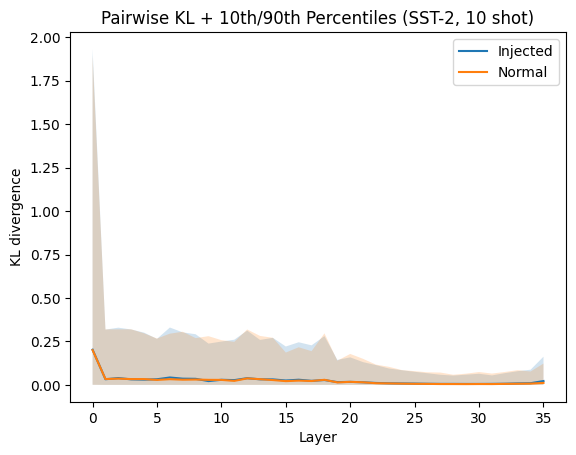

In [25]:
import matplotlib.pyplot as plt

def plot_curves(injected: th.Tensor, normal: th.Tensor):
    q = th.tensor([0.1, 0.5, 0.9])  # Lower, upper, and median
    lower_inj, median_inj, upper_inj = injected.quantile(q, dim=0)
    lower_normal, median_normal, upper_normal = normal.quantile(q, dim=0)

    plt.plot(median_inj, label="Injected")
    plt.plot(median_normal, label="Normal")

    # Add ribbons for the quantiles
    plt.fill_between(
        th.arange(len(median_inj)), lower_inj, upper_inj, alpha=0.2,
    )
    plt.fill_between(
        th.arange(len(median_normal)), lower_normal, upper_normal, alpha=0.2,
    )
    plt.legend()
    plt.xlabel("Layer")

plot_curves(pairwise_injected, pairwise_normal)
plt.title("Pairwise KL + 10th/90th Percentiles (SST-2, 10 shot)")
plt.ylabel("KL divergence")

In [20]:
from scipy.special import expit, log_softmax
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np


def winogrande_aurocs(stats):
    labels = []
    prob_array = []

    for h, v in stats.items():
        labels.append(v['label'] - 1)
        prob_array.append(v['log_likelihoods'])

    return np.mean(
        np.array(labels)[:, None] == np.argmax(prob_array, axis=1),
        axis=0
    )

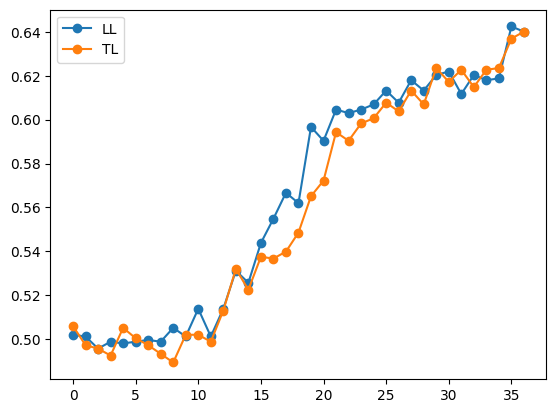

In [22]:
import matplotlib.pyplot as plt

plt.plot(winogrande_aurocs(per_doc_stats_ll['winogrande']), label="LL", marker='o')
plt.plot(winogrande_aurocs(per_doc_stats['winogrande']), label="TL", marker='o')
plt.legend()

Text(0.5, 1.0, 'Winogrande (Pythia 6.7B)')

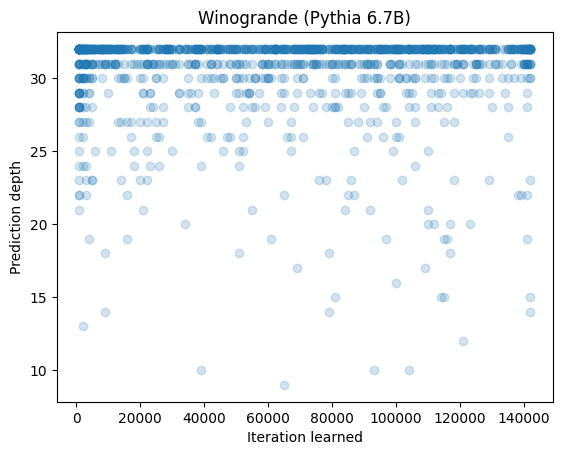

In [8]:
import matplotlib.pyplot as plt

plt.scatter(
    [(v + 1) * 1000 for k, v in sorted(iterations_learned["winogrande"].items())],
    [v for k, v in sorted(pred_depths["winogrande"].items())],
    alpha=0.2,
)
plt.xlabel("Iteration learned")
# plt.xscale("log")
plt.ylabel("Prediction depth")
plt.title("Winogrande (Pythia 6.7B)")

Text(0.5, 1.0, 'Winogrande (Pythia 6.7B)')

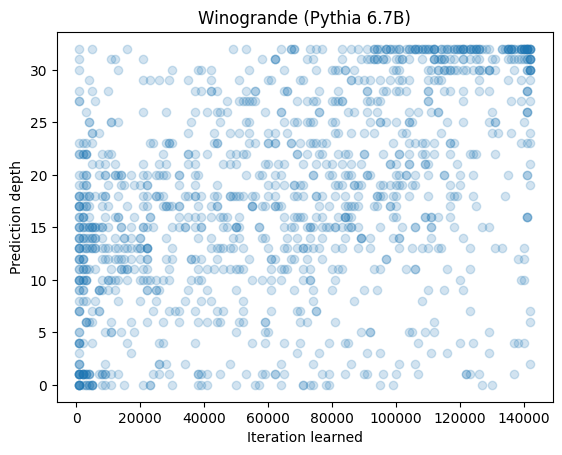

In [9]:
import matplotlib.pyplot as plt

plt.scatter(
    [(v + 1) * 1000 for k, v in sorted(iterations_learned["winogrande"].items())],
    [v for k, v in sorted(pred_depths_ll["winogrande"].items())],
    alpha=0.2,
)
plt.xlabel("Iteration learned")
# plt.xscale("log")
plt.ylabel("Prediction depth")
plt.title("Winogrande (Pythia 6.7B)")

In [37]:
import plotly.express as px
import numpy as np

px.density_heatmap(
    x=[np.log10((v + 1) * 1000) for k, v in sorted(iterations_learned["piqa"].items())],
    y=[v for k, v in sorted(pred_depths["piqa"].items())],
)

In [106]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-6.7b-deduped")

In [11]:
time_depth_rho

{'piqa': SpearmanrResult(correlation=0.6033688979496246, pvalue=2.9718697666156905e-179),
 'sciq': SpearmanrResult(correlation=0.5067962410752077, pvalue=2.3203689777523445e-66),
 'winogrande': SpearmanrResult(correlation=0.30245239628363446, pvalue=3.2669952415954215e-28),
 'arc_challenge': SpearmanrResult(correlation=0.5365395484844806, pvalue=3.3928269802558174e-88),
 'arc_easy': SpearmanrResult(correlation=0.5133595306690918, pvalue=1.3907709021194226e-159),
 'logiqa': SpearmanrResult(correlation=0.27093342226134337, pvalue=2.0442837474276335e-12)}

In [73]:
time_depth_rho_ll

{'lambada_openai': SpearmanrResult(correlation=0.04639190922178586, pvalue=0.0008667332006904759),
 'piqa': SpearmanrResult(correlation=0.22048656297826927, pvalue=2.7306999755191063e-21),
 'sciq': SpearmanrResult(correlation=0.20799051825571696, pvalue=3.099250346480388e-11),
 'wsc': SpearmanrResult(correlation=0.21743535036191636, pvalue=0.028947424028763043),
 'winogrande': SpearmanrResult(correlation=0.3123583659884361, pvalue=4.4955269619082434e-30),
 'arc_challenge': SpearmanrResult(correlation=0.3586634977251533, pvalue=7.700405182818333e-37),
 'arc_easy': SpearmanrResult(correlation=0.3898284748892458, pvalue=6.73113690892197e-87),
 'logiqa': SpearmanrResult(correlation=0.09393702324240655, pvalue=0.01650863239783208)}

In [64]:
confusions = {k: v["mean_kl"] for k, v in per_doc_tl.items()}

In [67]:
from scipy.stats import spearmanr, kendalltau

spearmanr(
    [v for k, v in sorted(time_depths.items())],
    [v for k, v in sorted(pred_depths.items())],
)

SpearmanrResult(correlation=0.09228800074420244, pvalue=3.220673818751161e-11)

In [1]:
tl_results = th.load("/mnt/ssd-1/nora/real-lenses/pythia/6.7b-deduped/affine/downstream/lambada_openai.pt")

NameError: name 'th' is not defined

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-1.3b-deduped")

Downloading:   0%|          | 0.00/394 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [23]:
greedy_preds = {k: tokenizer.decode(v["greedy_pred"][-1]) for k, v in per_doc_tl.items()}
path_lengths = {k: v["total_kl"] for k, v in per_doc_tl.items()}
entropies = {k: v["entropies"] for k, v in per_doc_tl.items()}
top1_probs = {k: v["top1_probs"] for k, v in per_doc_tl.items()}

In [51]:
from hashlib import md5
from lm_eval.tasks.lambada import LambadaOpenAI

task = LambadaOpenAI()
dataset = task.test_docs()
dataset = dataset.map(
    lambda x: {
        "hash": md5(task.doc_to_text(x).encode("utf-8")).hexdigest()
    },
).map(
    lambda x: {
        "pred": greedy_preds[x["hash"]],
        "depth": pred_depths[x["hash"]],
        "target": task.doc_to_target(x),
    },
)

No config specified, defaulting to: lambada_openai/default
Found cached dataset lambada_openai (/mnt/ssd-1/nora/huggingface/datasets/EleutherAI___lambada_openai/default/1.0.0/57baddecfa09d1790541ef07274c5666abfbe9d2ccd0cd46013cd557b0343095)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /mnt/ssd-1/nora/huggingface/datasets/EleutherAI___lambada_openai/default/1.0.0/57baddecfa09d1790541ef07274c5666abfbe9d2ccd0cd46013cd557b0343095/cache-304098ffcd08442e.arrow


  0%|          | 0/5153 [00:00<?, ?ex/s]

In [15]:
import pandas as pd

hits = {k: v["acc"][-1] for k, v in per_doc_stats["sciq"].items()}
df = pd.DataFrame.from_records([
    {
        "hash": k,
        "depth": v,
        "hit": hits[k],
    }
    for k, v in pred_depths["sciq"].items()
], index="hash")

KeyError: 'sciq'

In [100]:
from scipy.stats import spearmanr

spearmanr(
    df["depth"],
    df["hit"],
)

SpearmanrResult(correlation=-0.15581983510553715, pvalue=7.361828589138531e-07)

In [95]:
depth_bins = df.groupby(df.depth // 3)
accs = depth_bins.mean().hit
stderrs = depth_bins.hit.std() / depth_bins.count().hit ** 0.5

<AxesSubplot: title={'center': 'ARC Accuracy vs. Prediction Depth (Pythia 1.3B)'}, xlabel='Prediction Depth', ylabel='Accuracy'>

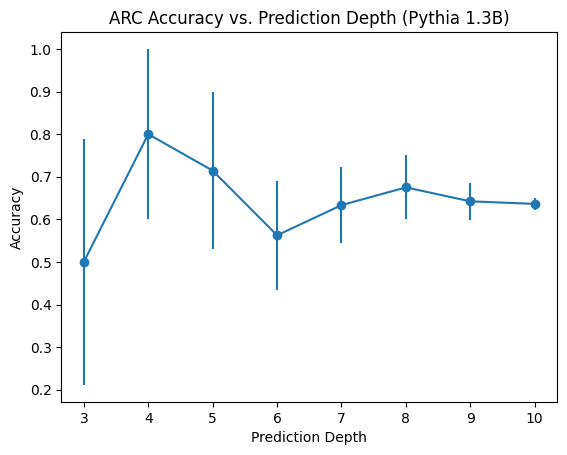

In [96]:
accs.plot(
    marker="o",
    title="ARC Accuracy vs. Prediction Depth (Pythia 1.3B)",
    xlabel="Prediction Depth",
    ylabel="Accuracy",
    yerr=stderrs
)

In [91]:
per_doc_ll = th.load("/mnt/ssd-1/nora/real-lenses/pythia/125m-deduped/affine/ll-downstream/lambada_openai_per_doc.pt")
ll_pred_depths = {
    k: min(
        i for i, pred in enumerate(v["greedy_pred"])
        if pred == v["greedy_pred"][-1]
    )
    for k, v in per_doc_ll.items()
    if v["greedy_pred"]
}

In [9]:
from lm_eval.tasks import ALL_TASKS, get_task
import inspect

def classify(cls):
    src = inspect.getsource(cls.construct_requests)

    if "greedy_until" in src:
        return "greedy_until"
    elif "loglikelihood_rolling" in src:
        return "loglikelihood_rolling"
    elif "loglikelihood" in src:
        return "loglikelihood"
    else:
        return "unknown"

task_to_type = {
    task_name: classify(get_task(task_name))
    for task_name in ALL_TASKS
}

In [15]:
import functorch as fth
import torch.nn.functional as F
import torch as th

x0 = 3 * th.tensor([1, 0, 1, 0.0, 1, 0])
fth.jacfwd(lambda x: F.layer_norm(x, (x.shape[-1],)))(x0)

tensor([[ 4.4444e-01, -4.7684e-07, -2.2222e-01, -4.9174e-07, -2.2222e-01,
         -4.7684e-07],
        [-4.9174e-07,  4.4444e-01, -4.9174e-07, -2.2222e-01, -4.9174e-07,
         -2.2222e-01],
        [-2.2222e-01, -4.7684e-07,  4.4444e-01, -4.9174e-07, -2.2222e-01,
         -4.7684e-07],
        [-4.9174e-07, -2.2222e-01, -4.9174e-07,  4.4444e-01, -4.9174e-07,
         -2.2222e-01],
        [-2.2222e-01, -4.7684e-07, -2.2222e-01, -4.9174e-07,  4.4444e-01,
         -4.7684e-07],
        [-4.9174e-07, -2.2222e-01, -4.9174e-07, -2.2222e-01, -4.9174e-07,
          4.4444e-01]])